# 0.数据集介绍与实验准备

## 数据集介绍
本数据集是有两个特征，一个是时间，一个是顾客量，是某单位1949年到1960年每个月的顾客量。本例利用ARIMA时序分析算法，预测顾客量。

## 实验准备

### 进入ModelArts界面

点击如下链接：https://www.huaweicloud.com/product/modelarts.html ，进入ModelArts主页。点击“立即使用”按钮，输入用户名和密码登录，进入ModelArts使用页面。

### 创建ModelArts Notebook

下面，我们在ModelArts中创建一个notebook开发环境，ModelArts notebook提供网页版的Python开发环境，可以方便的编写、运行代码，并查看运行结果。

第一步：在ModelArts服务主界面依次点击“开发环境”、“创建”

![create_nb_create_button](./img/create_nb_create_button.png)

第二步：填写notebook所需的参数：

| 参数 | 说明 |
| - - - - - | - - - - - |
| 计费方式 | 按需计费  |
| 名称 | Notebook实例名称，如 kmeans_customer_segmentation |
| 工作环境 | Python3 |
| 资源池 | 选择"公共资源池"即可 |
| 类型 | CPU |
| 规格 | 2核8GiB |
| 存储配置 | 选择EVS，磁盘规格5GB |

第三步：配置好notebook参数后，点击下一步，进入notebook信息预览。确认无误后，点击“立即创建”

![create_nb_creation_summary](./img/create_nb_creation_summary.png)

第四步：创建完成后，返回开发环境主界面，等待Notebook创建完毕后，打开Notebook，进行下一步操作。
![modelarts_notebook_index](./img/modelarts_notebook_index.png)

### 在ModelArts中创建开发环境

接下来，我们创建一个实际的开发环境，用于后续的实验步骤。

第一步：点击下图所示的“打开”按钮，进入刚刚创建的Notebook
![inter_dev_env](img/enter_dev_env.png)

第二步：创建一个Python3环境的的Notebook。点击右上角的"New"，然后创建 XGBoost-Sklearn 开发环境。

第三步：点击左上方的文件名"Untitled"，并输入一个与本实验相关的名称，如"wine-quality-regresiion"
![notebook_untitled_filename](./img/notebook_untitled_filename.png)
![notebook_name_the_ipynb](./img/notebook_name_the_ipynb.png)


### 在Notebook中编写并执行代码

在Notebook中，我们输入一个简单的打印语句，然后点击上方的运行按钮，可以查看语句执行的结果：
![run_helloworld](./img/run_helloworld.png)


开发环境准备好啦，接下来可以愉快地写代码啦！


## 导入类库

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
from matplotlib.pylab import rcParams
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from pandas.core.frame import DataFrame
import statsmodels.api as sm    
import statsmodels.tsa.api as smt 
from statsmodels.tsa.seasonal import seasonal_decompose
import requests
#rcParams设定好画布的大小
rcParams['figure.figsize'] = 17, 8

/home/ma-user/anaconda3/envs/PySpark-2.3.2/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


# 1.数据分析

## 1.1数据读取并转换为时序类型

本样例数据已经预先被上传到公共OBS桶里，我们只需要下载读取即可，显示前五行如下

In [12]:
dateparse = lambda dates: pd.datetime.strptime(dates, '%Y-%m')
url = 'https://modelarts-labs.obs.cn-north-1.myhuaweicloud.com/notebook/ML_air_passengers/AirPassengers.csv'
r = requests.get(url) 
with open("./AirPassengers.csv", "wb") as code:
    code.write(r.content)
data = pd.read_csv('./AirPassengers.csv', parse_dates=['Month'], index_col='Month',date_parser=dateparse)
data.head(5)

,#Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


# 1.2数据稳定性分析
判断数据是否稳定常基于以下几个统计量：

1.均值

2.方差

3.自协方差

下图我们以一年为一个窗口，每一个时间t的值由它前面12个月（包括自己）的均值代替（标准差同理），看看均值和标准差是否稳定。

由于原数据值域范围比较大，为了缩小值域，同时保留其他信息，常用的方法是对数化，取log。所以我们先将数值取log，然后求得起移动均值和标准差如下图所示。



/home/ma-user/anaconda3/envs/PySpark-2.3.2/lib/python3.6/site-packages/ipykernel/__main__.py:4: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).mean()
/home/ma-user/anaconda3/envs/PySpark-2.3.2/lib/python3.6/site-packages/ipykernel/__main__.py:5: FutureWarning: pd.rolling_std is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).std()


Results of Dickey-Fuller Test:
Test Statistic                   0.815369
p-value                          0.991880
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical value (1%)             -3.481682
Critical value (5%)             -2.884042
Critical value (10%)            -2.578770
dtype: float64


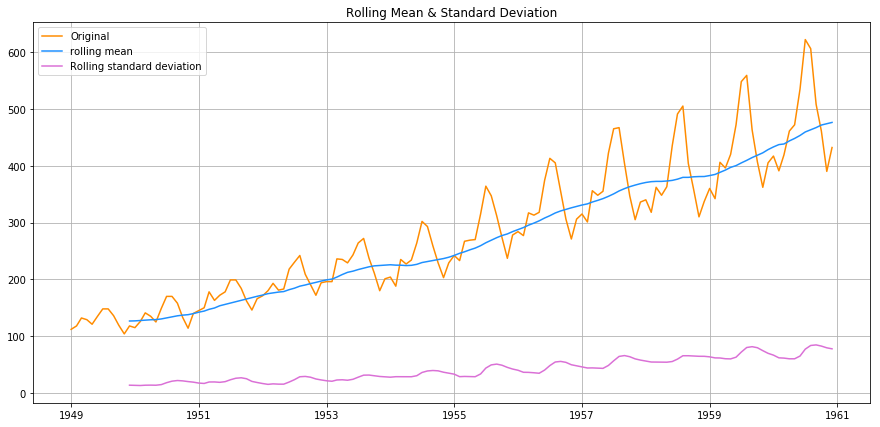

In [14]:
def test_stationarity(timeseries,months=12):
    
    #这里以一年为一个窗口，每一个时间t的值由它前面12个月（包括自己）的均值代替，标准差同理。
    rolmean = pd.rolling_mean(timeseries,window=months)
    rolstd = pd.rolling_std(timeseries, window=months)
    #plot rolling statistics:
#     plt.figure(figsize=(17, 8)) 
    fig = plt.figure(figsize=(15, 7))
    fig.add_subplot()
    orig = plt.plot(timeseries, color = 'darkorange',label='Original')
    mean = plt.plot(rolmean , color = 'dodgerblue',label = 'rolling mean')
    std = plt.plot(rolstd, color = 'orchid', label= 'Rolling standard deviation')
    plt.legend(loc = 'best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.grid(True);
    #Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries,autolag = 'AIC')
    #dftest的输出前一项依次为检测值，p值，滞后数，使用的观测数，各个置信度下的临界值
    dfoutput = pd.Series(dftest[0:4],index = ['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical value (%s)' %key] = value
    
    print (dfoutput)
    
ts = data['#Passengers']
ts_log = np.log(ts)

test_stationarity(ts)


可以看到，数据的平均均值/标准差具有越来越大的趋势，是不稳定的。

且DF-test可以明确的指出，在任何置信度下，数据都不是稳定的。

另外我这里test_stationarity函数其中一个参数months代表以多少个月为一个窗口，读者也可以修改其数值，观测用不同大小的窗口得到的平均值结果如何。

# 2.将数据变稳
将数据变稳定的方法有差分法、平滑等方法。

## 2.1移动平均法
我们对原数据作移动平滑，并将原数据与平滑后的结果作差，然后绘制作差后的曲线与它的均值和标准差曲线。

我们从下面可以看到，移动平均处理后的数据基本上没有了随时间变化的趋势，DFtest的结果告诉我们在95%的置信度下，数据是稳定的。

/home/ma-user/anaconda3/envs/PySpark-2.3.2/lib/python3.6/site-packages/ipykernel/__main__.py:1: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).mean()
  if __name__ == '__main__':
/home/ma-user/anaconda3/envs/PySpark-2.3.2/lib/python3.6/site-packages/ipykernel/__main__.py:4: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).mean()
/home/ma-user/anaconda3/envs/PySpark-2.3.2/lib/python3.6/site-packages/ipykernel/__main__.py:5: FutureWarning: pd.rolling_std is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).std()


Results of Dickey-Fuller Test:
Test Statistic                  -3.162908
p-value                          0.022235
#Lags Used                      13.000000
Number of Observations Used    119.000000
Critical value (1%)             -3.486535
Critical value (5%)             -2.886151
Critical value (10%)            -2.579896
dtype: float64


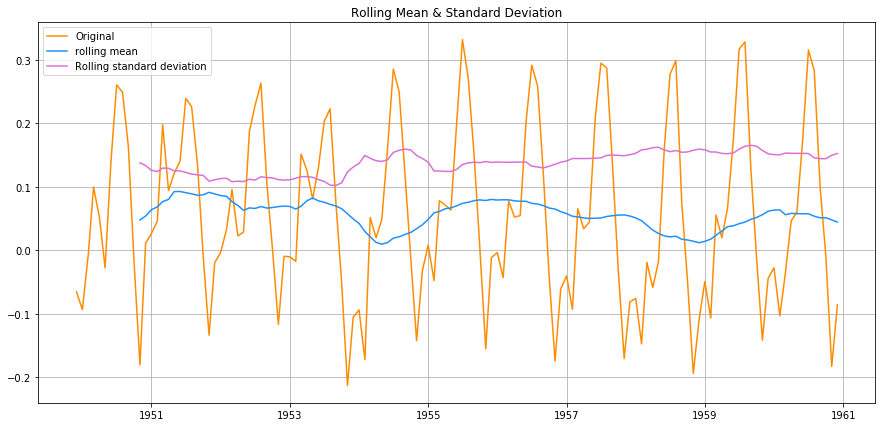

In [17]:
moving_avg = pd.rolling_mean(ts_log,12)
ts_log_moving_avg_diff = ts_log-moving_avg
ts_log_moving_avg_diff.dropna(inplace = True)
test_stationarity(ts_log_moving_avg_diff,12)

## 2.2指数加权移动平滑
上面的方法是将所有的时间平等看待，而在许多情况下，可以认为越近的时刻越重要，所以也可以用引入指数加权移动平均的方法。下面函数中，alpha 是一个平滑因子，它的值介于 0 和 1 之间。它决定了之前观测值的权重下降的速度，我将其设置为0.3，读者也可以设置为其他值观察效果如何。

我们对原数据作指数加权移动平滑，绘制出平滑后的曲线。并将原数据与平滑后的结果作差，然后绘制作差后的曲线与它的均值和标准差曲线。

可以看到相比普通的Moving Average，新的数据平均标准差更小了。而且DFtest可以得到结论：数据在99%的置信度上是稳定的。

          
alpha is 0.3:
Results of Dickey-Fuller Test:


/home/ma-user/anaconda3/envs/PySpark-2.3.2/lib/python3.6/site-packages/ipykernel/__main__.py:4: FutureWarning: pd.rolling_mean is deprecated for ndarrays and will be removed in a future version
/home/ma-user/anaconda3/envs/PySpark-2.3.2/lib/python3.6/site-packages/ipykernel/__main__.py:5: FutureWarning: pd.rolling_std is deprecated for ndarrays and will be removed in a future version


Test Statistic                  -2.799681
p-value                          0.058319
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical value (1%)             -3.481682
Critical value (5%)             -2.884042
Critical value (10%)            -2.578770
dtype: float64


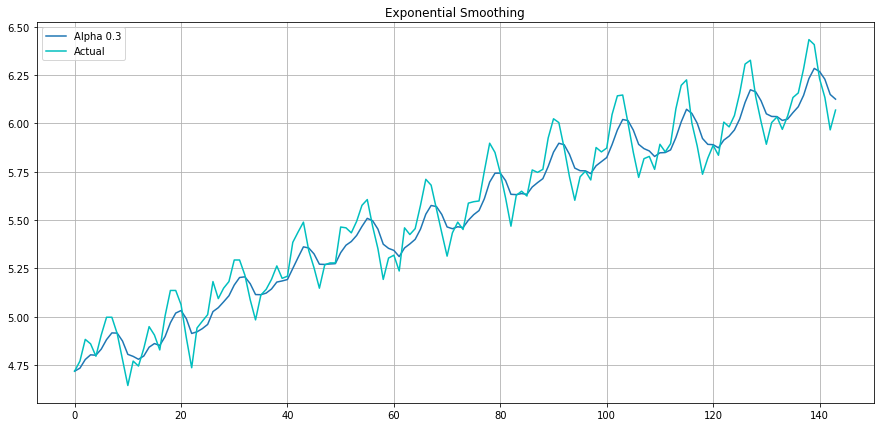

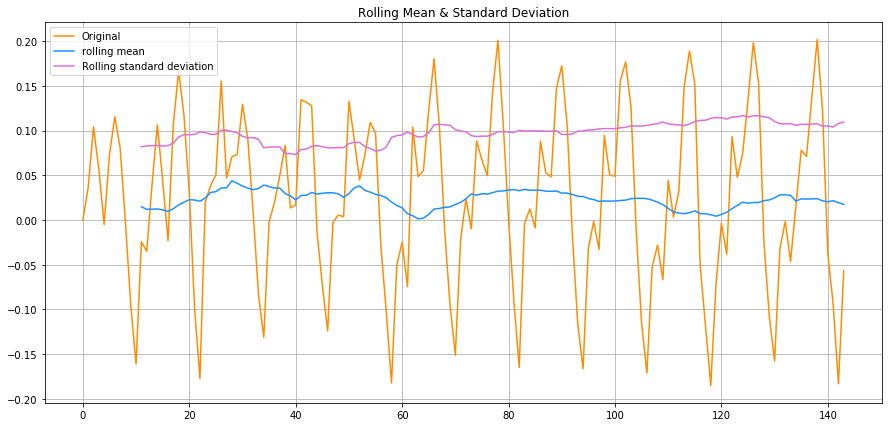

In [16]:
def exponential_smoothing(series, alpha):
    result = [series[0]]
    
    for n in range(1, len(series)):    
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])    

    return result    

def plot_exponential_smoothing(series, alphas):    
    plt.figure(figsize=(15, 7))    
    for alpha in alphas:    
        plt.plot(exponential_smoothing(series, alpha), label="Alpha {}".format(alpha))    
        plt.plot(series.values, "c", label = "Actual")    
        plt.legend(loc="best")    
        plt.axis('tight')    
        plt.title("Exponential Smoothing")    
        plt.grid(True);    

def plot_diff_exponential_smoothing(series, alphas):    
    series_np=np.array(series)
    for alpha in alphas:
        ts_log_ewma_diff=series_np-exponential_smoothing(series, alpha)
        print("          ")
        print("alpha is {}:".format(alpha))
        test_stationarity(ts_log_ewma_diff,12)        
al = 1 - np.exp(np.log(0.5) / 12)
plot_exponential_smoothing(ts_log, [0.3])  
plot_diff_exponential_smoothing(ts_log, [0.3])

## 2.3双指数加权移动平滑
当时间序列中存在趋势时，可以双指数平滑。在这种情况下，它是指数平滑的两次递归使用，它的数学公式可以在下面double_exponential_smoothing函数里看到。函数里这里，beta 是趋势平滑因子，它的值介于 0 和 1 之间，我将其设为0.8，读者也可以设置为其他值对比一下效果。

我们对原数据作指数加权移动平滑，绘制出平滑后的曲线。并将原数据与平滑后的结果作差，然后绘制作差后的曲线与它的均值和标准差曲线,DFtest可以得到结论：数据在99%的置信度上是稳定的。


          
alpha is 0.3,beta is0.8:
Results of Dickey-Fuller Test:
Test Statistic                  -3.538801
p-value                          0.007045
#Lags Used                      14.000000
Number of Observations Used    129.000000
Critical value (1%)             -3.482088
Critical value (5%)             -2.884219
Critical value (10%)            -2.578864
dtype: float64


/home/ma-user/anaconda3/envs/PySpark-2.3.2/lib/python3.6/site-packages/ipykernel/__main__.py:4: FutureWarning: pd.rolling_mean is deprecated for ndarrays and will be removed in a future version
/home/ma-user/anaconda3/envs/PySpark-2.3.2/lib/python3.6/site-packages/ipykernel/__main__.py:5: FutureWarning: pd.rolling_std is deprecated for ndarrays and will be removed in a future version


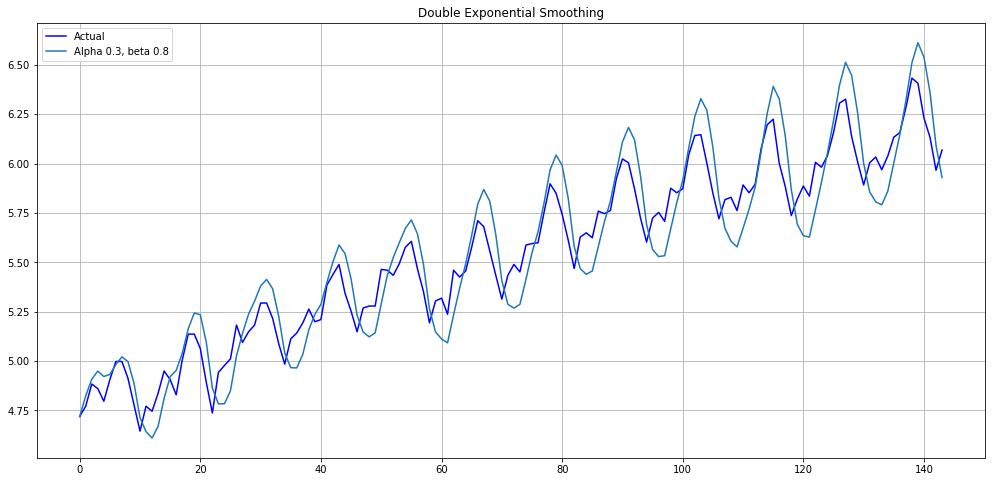

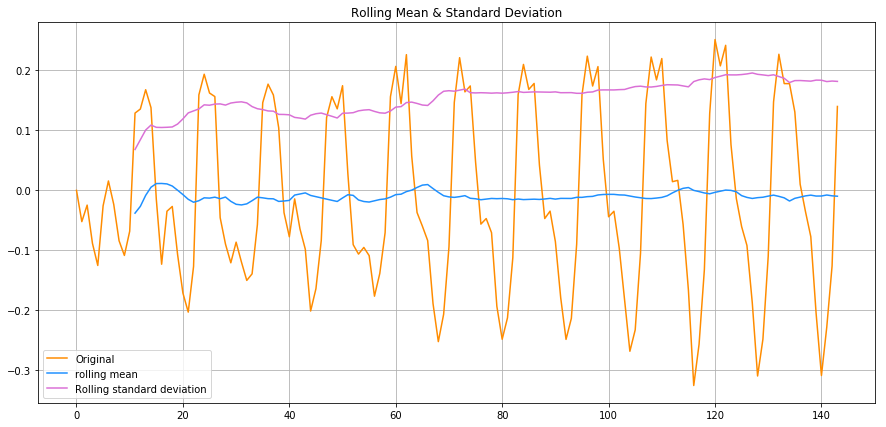

In [18]:
def double_exponential_smoothing(series, alpha, beta):    

    result = [series[0]]    
    for n in range(1, len(series)+1):    
        if n == 1:    
            level, trend = series[0], series[1] - series[0]    
        if n >= len(series): # forecasting    
            value = result[-1]    
        else:    
            value = series[n]    
            last_level, level = level, alpha * value + (1 - alpha) * (level + trend)    
            trend = beta * (level - last_level) + (1 - beta) * trend    
            result.append(level + trend)    
    return result    


def plot_double_exponential_smoothing(series, alphas, betas):    
    plt.figure(figsize=(17, 8))    
    plt.plot(series.values, "b", label = "Actual")
    for alpha in alphas:    
        for beta in betas:    
            plt.plot(double_exponential_smoothing(series, alpha, beta), label="Alpha {}, beta {}".format(alpha, beta))    
            plt.legend(loc="best")    
            plt.axis('tight')    
            plt.title("Double Exponential Smoothing")    
            plt.grid(True)    

def plot_double_exponential_diff_smoothing(series, alphas, betas):    
        series_np=np.array(series)
        for alpha in alphas:
            for beta in betas: 
                ts_log_ewma_diff=series_np-double_exponential_smoothing(series, alpha, beta)
                print("          ")
                print("alpha is {},beta is{}:".format(alpha,beta))
                test_stationarity(ts_log_ewma_diff,12) 

plot_double_exponential_smoothing(ts_log, alphas=[0.3], betas=[0.8])    
plot_double_exponential_diff_smoothing(ts_log, alphas=[0.3], betas=[0.8])    

##  2.4差分法
差分法指将原值与特定滞后数目的时刻的值的作差。
我们对原数据作滞后，绘制出滞后的曲线。并将原数据与滞后后的结果作差，然后绘制作差后的曲线与它的均值和标准差曲线。

下图可以看到以差分法处理后的数据的均值和方差的在时间轴上的振幅明显缩小了。DFtest的结论是在90%的置信度下，数据是稳定的。

/home/ma-user/anaconda3/envs/PySpark-2.3.2/lib/python3.6/site-packages/ipykernel/__main__.py:5: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).mean()
/home/ma-user/anaconda3/envs/PySpark-2.3.2/lib/python3.6/site-packages/ipykernel/__main__.py:6: FutureWarning: pd.rolling_std is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).std()


Results of Dickey-Fuller Test:
Test Statistic                  -2.717131
p-value                          0.071121
#Lags Used                      14.000000
Number of Observations Used    128.000000
Critical value (1%)             -3.482501
Critical value (5%)             -2.884398
Critical value (10%)            -2.578960
dtype: float64


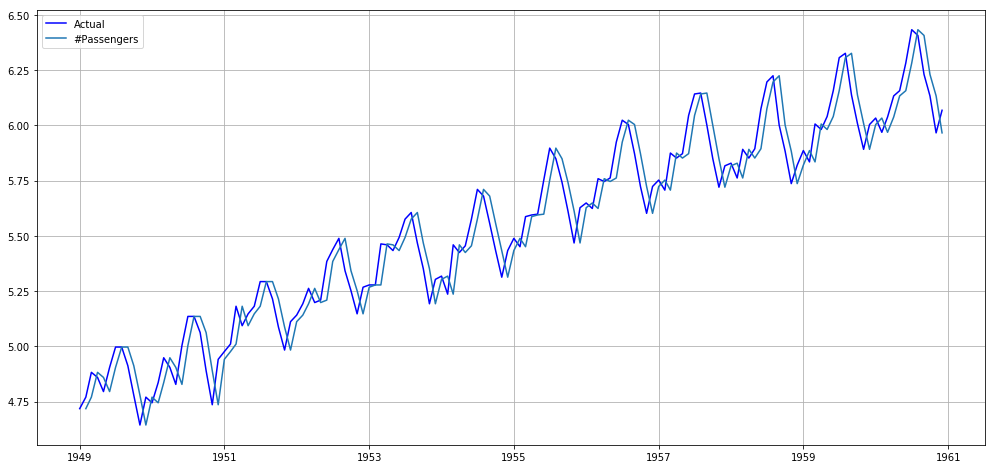

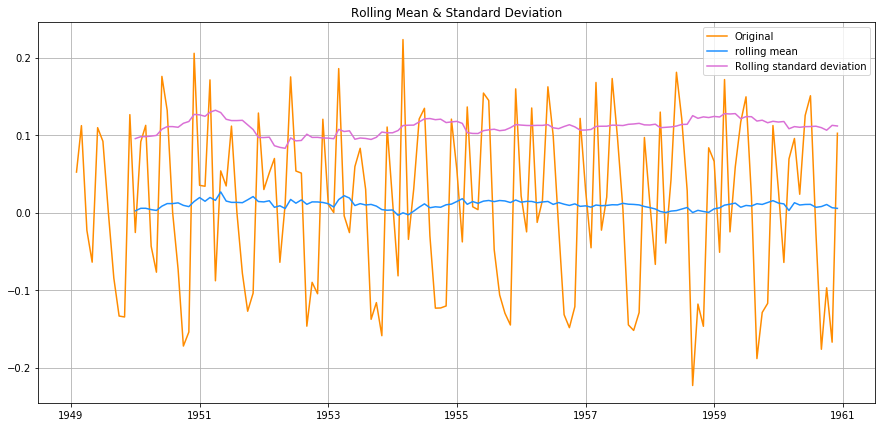

In [89]:
def plot_log_differencing_smoothing(series):    
    plt.figure(figsize=(17, 8))    
    plt.plot(series, "b", label = "Actual")
    plt.plot(ts_log.shift())    
    plt.legend(loc="best")        
    plt.grid(True)    

def plot_log_differencing_diff_smoothing(series):    
        series_shift= series.shift()
        ts_log_diff =series - series_shift
        ts_log_diff.dropna(inplace=True)
        test_stationarity(ts_log_diff,12) 
    
plot_log_differencing_smoothing(ts_log)   
plot_log_differencing_diff_smoothing(ts_log)

# 3.模型构建

## 3.1参数确定
我们上面可以看到，数据经过移动平均或者指数平均或者差分法之后均已稳定，这里我们以差分法使其稳定为例，建立ARIMA模型。

ARIMA算法有(p,d,q)三个参数，由于上述是利用一阶差分法，所以d取1。接下来我们确定p,q两个参数，我们首先画出ACF,PACF图像。如下所示：

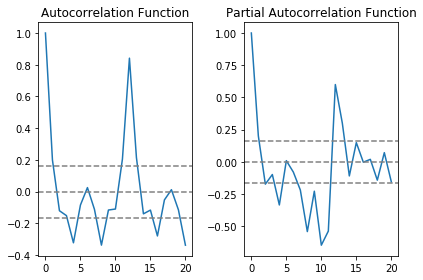

In [42]:
#ACF and PACF plots:
# ts_log_diff=residual
data = pd.read_csv('AirPassengers.csv', parse_dates=['Month'], index_col='Month',date_parser=dateparse)

ts = data['#Passengers']
ts_log = np.log(ts)
ts_log_diff = ts_log - ts_log.shift()
ts_log_diff.dropna(inplace=True)
from statsmodels.tsa.stattools import acf, pacf
lag_acf = acf(ts_log_diff, nlags=20)
lag_pacf = pacf(ts_log_diff, nlags=20, method='ols')
#Plot ACF: 
plt.subplot(121) 
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.title('Autocorrelation Function')

#Plot PACF:
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()

## 3.2模型建立
图上中，上下两条灰线之间是置信区间，p的值就是ACF第一次穿过上置信区间时的横轴值。q的值就是PACF第一次穿过上置信区间的横轴值。所以从图中可以得到p=2，q=2。

得到参数估计值p，d，q之后，生成模型ARIMA（p，d，q）如下所示，下图中，蓝线是输入值，红线是模型的拟合值，RSS的累计平方误差。

/home/ma-user/anaconda3/envs/PySpark-2.3.2/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:646: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):
/home/ma-user/anaconda3/envs/PySpark-2.3.2/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:650: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  elif issubdtype(paramsdtype, complex):
/home/ma-user/anaconda3/envs/PySpark-2.3.2/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:577: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsd

Text(0.5,1,'RSS: 0.7302')

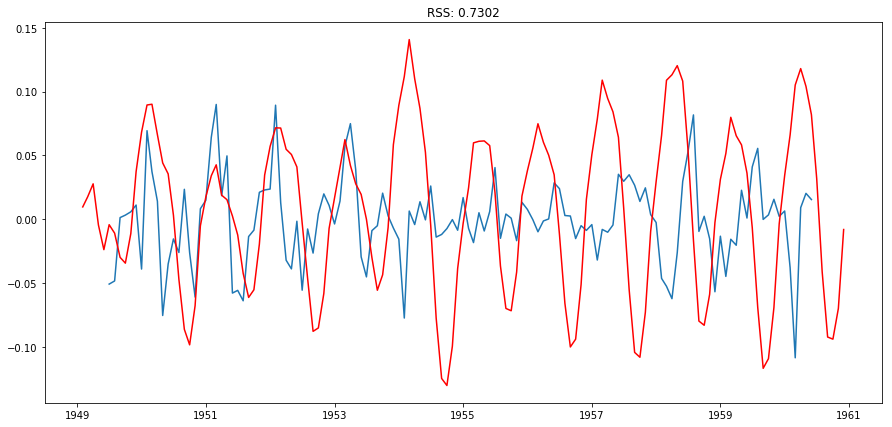

In [52]:
from statsmodels.tsa.arima_model import ARIMA
ts_log_diff = residual
ts_log_diff.dropna(inplace=True)
fig = plt.figure(figsize=[15,7]) 
model = ARIMA(ts_log, order=(2, 1, 2))  
results_ARIMA = model.fit(disp=-1)  
plt.plot(ts_log_diff)
plt.plot(results_ARIMA.fittedvalues, color='red')
div=results_ARIMA.fittedvalues-ts_log_diff
div.dropna(inplace=True)
plt.title('RSS: %.4f'% sum((div)**2))

## 3.3模型预测
因为上面的模型的拟合值是对原数据进行稳定化之后的输入数据的拟合，所以需要对拟合值进行相应处理的逆操作，使得它回到与原数据一致的尺度。

下图表示的是原始值和预测值以及RMSE误差值。

Month
1949-02-01    0.009580
1949-03-01    0.017491
1949-04-01    0.027670
1949-05-01   -0.004521
1949-06-01   -0.023890
dtype: float64


/home/ma-user/anaconda3/envs/PySpark-2.3.2/lib/python3.6/site-packages/ipykernel/__main__.py:11: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated


Text(0.5,1,'RMSE: 90.1051')

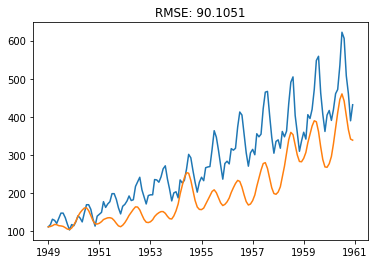

In [54]:
#ARIMA拟合的其实是一阶差分ts_log_diff，predictions_ARIMA_diff[i]是第i个月与i-1个月的ts_log的差值。
#由于差分化有一阶滞后，所以第一个月的数据是空的，
predictions_ARIMA_diff = pd.Series(results_ARIMA.fittedvalues, copy=True)
print (predictions_ARIMA_diff.head())
#累加现有的diff，得到每个值与第一个月的差分（同log底的情况下）。
#即predictions_ARIMA_diff_cumsum[i] 是第i个月与第1个月的ts_log的差值。
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
#先ts_log_diff => ts_log=>ts_log => ts 
#先以ts_log的第一个值作为基数，复制给所有值，然后每个时刻的值累加与第一个月对应的差值(这样就解决了，第一个月diff数据为空的问题了)
#然后得到了predictions_ARIMA_log => predictions_ARIMA
predictions_ARIMA_log = pd.Series(ts_log.ix[0], index=ts_log.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum,fill_value=0)
predictions_ARIMA = np.exp(predictions_ARIMA_log)
plt.figure()
plt.plot(ts)
plt.plot(predictions_ARIMA)
plt.title('RMSE: %.4f'% np.sqrt(sum((predictions_ARIMA-ts)**2)/len(ts)))